In [ ]:
! unzip /content/archive.zip

Archive:  /content/archive.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Load training data
train_df = pd.read_csv('/content/train.csv')  # path to your training data

# Preprocess text
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(train_df['text'])
text_sequences = text_tokenizer.texts_to_sequences(train_df['text'])
text_padded = pad_sequences(text_sequences, padding='post')

# Preprocess aspects
aspect_tokenizer = Tokenizer()
aspect_tokenizer.fit_on_texts(train_df['aspect'])
aspect_sequences = aspect_tokenizer.texts_to_sequences(train_df['aspect'])
aspect_padded = pad_sequences(aspect_sequences, padding='post')

# Preprocess labels (one-hot encoding)
labels = to_categorical(train_df['label'].values)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(np.concatenate((text_padded, aspect_padded), axis=1), labels, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model parameters
text_vocab_size = len(text_tokenizer.word_index) + 1
aspect_vocab_size = len(aspect_tokenizer.word_index) + 1
embedding_dim = 100
lstm_units = 64
num_classes = labels.shape[1]  # Number of sentiment classes
l2_reg = 0.001  # L2 regularization factor

# Text input branch
text_input = Input(shape=(text_padded.shape[1],))
text_embedding = Embedding(input_dim=text_vocab_size, output_dim=embedding_dim)(text_input)
text_lstm = Bidirectional(LSTM(lstm_units, return_sequences=False, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(l2_reg)))(text_embedding)

# Aspect input branch
aspect_input = Input(shape=(aspect_padded.shape[1],))
aspect_embedding = Embedding(input_dim=aspect_vocab_size, output_dim=embedding_dim)(aspect_input)
aspect_lstm = Bidirectional(LSTM(lstm_units, return_sequences=False, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(l2_reg)))(aspect_embedding)

# Concatenate the outputs of the two branches
concatenated = Concatenate()([text_lstm, aspect_lstm])

# Fully connected layers
dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(concatenated)
dropout_layer = Dropout(0.6)(dense_layer)  # Increased dropout rate
output_layer = Dense(num_classes, activation='softmax')(dropout_layer)

# Build and compile the model
model = Model(inputs=[text_input, aspect_input], outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)





In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 271)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 271, 100)             486700    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 8, 100)               101800    ['input_2[0][0]']             
                                                                                              

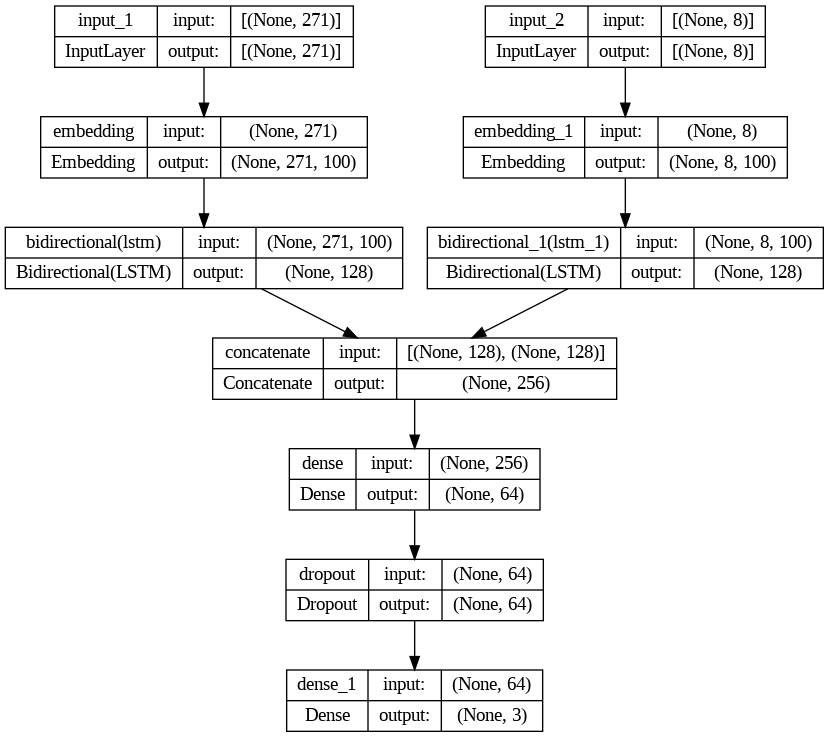

In [ ]:
from tensorflow.keras.utils import plot_model

# Plotting the model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Displaying the model architecture image in Google Colab
from IPython.display import Image
Image('model_architecture.png')


In [ ]:
history = model.fit([X_train[:, :text_padded.shape[1]], X_train[:, text_padded.shape[1]:]], y_train, batch_size=32, epochs=100, validation_split=0.2,callbacks =[early_stopping, reduce_lr])


Epoch 1/100
80/80 [==============================] - 60s 659ms/step - loss: 1.4234 - accuracy: 0.4098 - val_loss: 1.1884 - val_accuracy: 0.4563 - lr: 0.0010
Epoch 2/100
80/80 [==============================] - 49s 616ms/step - loss: 1.0347 - accuracy: 0.5605 - val_loss: 0.9833 - val_accuracy: 0.5547 - lr: 0.0010
Epoch 3/100
80/80 [==============================] - 50s 632ms/step - loss: 0.8275 - accuracy: 0.6836 - val_loss: 0.8600 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 4/100
80/80 [==============================] - 50s 625ms/step - loss: 0.6505 - accuracy: 0.7832 - val_loss: 0.8851 - val_accuracy: 0.6297 - lr: 0.0010
Epoch 5/100
80/80 [==============================] - 50s 624ms/step - loss: 0.5120 - accuracy: 0.8398 - val_loss: 0.9092 - val_accuracy: 0.6578 - lr: 0.0010
Epoch 6/100
80/80 [==============================] - 48s 603ms/step - loss: 0.4199 - accuracy: 0.8816 - val_loss: 1.0763 - val_accuracy: 0.6234 - lr: 0.0010


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])  # Assuming 'label' is your sentiment label column

# Save the fitted LabelEncoder for later use
import pickle
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)


In [ ]:
# Load test data
test_df = pd.read_csv('/content/test.csv')  # Replace with the path to your test data

# Preprocess text in test data
test_text_sequences = text_tokenizer.texts_to_sequences(test_df['text'])
test_text_padded = pad_sequences(test_text_sequences, maxlen=text_padded.shape[1], padding='post')

# Preprocess aspects in test data
test_aspect_sequences = aspect_tokenizer.texts_to_sequences(test_df['aspect'])
test_aspect_padded = pad_sequences(test_aspect_sequences, maxlen=aspect_padded.shape[1], padding='post')

# Make predictions
predictions = model.predict([test_text_padded, test_aspect_padded])

# The predictions are in the form of class probabilities, you can convert them to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Load the previously saved LabelEncoder
with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

# Inverse transform to get original sentiment labels
sentiment_labels = label_encoder.inverse_transform(predicted_labels)

# Example: printing the first few predictions
for i in range(5):
    print(f"Text: {test_df['text'][i]}")
    print(f"Aspect: {test_df['aspect'][i]}")
    print(f"Predicted Sentiment: {sentiment_labels[i]}")
    print("----------")


32/32 [==============================] - 3s 79ms/step
Text: improve your customer service and product availability
Aspect: Customer service
Predicted Sentiment: 0
----------
Text: functionality is great, almost as in desktop version, but mobile version needs a lot of improvement esp the speed
Aspect: mobile version
Predicted Sentiment: 1
----------
Text: but it keeps starting from zoomed in and then slowly zooming out as the music plays.
Aspect: zoomed
Predicted Sentiment: 0
----------
Text: hey marilyn thanks for your answer the soc2 type 1 certification is a document that can be shared with external parties for security assessment do you have a copy of the report we could explore?
Aspect: Security
Predicted Sentiment: 1
----------
Text: @delanovc @zoom @airtable @notionhq @calendly apple x lulu would be the most interesting if they ever expand their.
Aspect: apple
Predicted Sentiment: 1
----------


In [ ]:
# Custom sentence and aspect
custom_sentence = "the food was great."
custom_aspect = "food"
# Tokenize and pad the custom sentence
custom_text_sequence = text_tokenizer.texts_to_sequences([custom_sentence])
custom_text_padded = pad_sequences(custom_text_sequence, maxlen=text_padded.shape[1], padding='post')

# Tokenize and pad the custom aspect
custom_aspect_sequence = aspect_tokenizer.texts_to_sequences([custom_aspect])
custom_aspect_padded = pad_sequences(custom_aspect_sequence, maxlen=aspect_padded.shape[1], padding='post')
custom_prediction = model.predict([custom_text_padded, custom_aspect_padded])

# Convert the prediction to a sentiment label
custom_predicted_label = np.argmax(custom_prediction, axis=1)
custom_sentiment_label = label_encoder.inverse_transform(custom_predicted_label)

print(f"Custom Sentence: {custom_sentence}")
print(f"Aspect: {custom_aspect}")
print(f"Predicted Sentiment: {custom_sentiment_label[0]}")

1/1 [==============================] - 0s 50ms/step
Custom Sentence: the food was great.
Aspect: food
Predicted Sentiment: 2


In [ ]:
# Custom sentence and aspect
custom_sentence = "the display is worst"
custom_aspect = "display"
# Tokenize and pad the custom sentence
custom_text_sequence = text_tokenizer.texts_to_sequences([custom_sentence])
custom_text_padded = pad_sequences(custom_text_sequence, maxlen=text_padded.shape[1], padding='post')

# Tokenize and pad the custom aspect
custom_aspect_sequence = aspect_tokenizer.texts_to_sequences([custom_aspect])
custom_aspect_padded = pad_sequences(custom_aspect_sequence, maxlen=aspect_padded.shape[1], padding='post')
custom_prediction = model.predict([custom_text_padded, custom_aspect_padded])

# Convert the prediction to a sentiment label
custom_predicted_label = np.argmax(custom_prediction, axis=1)
custom_sentiment_label = label_encoder.inverse_transform(custom_predicted_label)

print(f"Custom Sentence: {custom_sentence}")
print(f"Aspect: {custom_aspect}")
print(f"Predicted Sentiment: {custom_sentiment_label[0]}")

1/1 [==============================] - 0s 48ms/step
Custom Sentence: the display is worst
Aspect: display
Predicted Sentiment: 0
